# Anthropic Interviewer – Human-Only Conversation Dataset

**Dataset source:** Hugging Face `Anthropic/AnthropicInterviewer` (workforce, creatives, scientists splits).

**Goal:** Merge all splits and keep only human speech for analysis — one row per transcript with human turns in chronological order.

## BDD

### Imports et préparation

In [1]:
# pip install datasets pandas tqdm pyarrow  # uncomment if needed

from datasets import load_dataset
import pandas as pd
import re
from tqdm import tqdm
from pathlib import Path

### BDD et préparation – Chargement et fusion des splits

In [2]:
ds = load_dataset("Anthropic/AnthropicInterviewer")

workforce = ds["workforce"].to_pandas()
creatives = ds["creatives"].to_pandas()
scientists = ds["scientists"].to_pandas()

workforce["split"] = "workforce"
creatives["split"] = "creatives"
scientists["split"] = "scientists"

df_raw = pd.concat([
    workforce[["split", "transcript_id", "text"]],
    creatives[["split", "transcript_id", "text"]],
    scientists[["split", "transcript_id", "text"]],
], ignore_index=True)

print("Shape:", df_raw.shape)
print("\nSplit counts:")
print(df_raw["split"].value_counts())

Shape: (1250, 3)

Split counts:
split
workforce     1000
creatives      125
scientists     125
Name: count, dtype: int64


### Utilitaires de parsing (speaker, nettoyage, transcript)

In [3]:
def detect_speaker(line):
    """Return 'AI', 'HUMAN', or 'unknown' based on line prefix."""
    line_lower = line.strip().lower()
    if any(line_lower.startswith(p) for p in ("assistant:", "claude:", "interviewer:")):
        return "AI"
    if any(line_lower.startswith(p) for p in ("user:", "participant:", "interviewee:")):
        return "HUMAN"
    return "unknown"


def clean_text(text):
    """Remove speaker prefix and normalize whitespace."""
    if not text or not isinstance(text, str):
        return ""
    text = re.sub(r"^(Assistant|Claude|Interviewer|User|Participant|Interviewee):\s*", "", text, flags=re.IGNORECASE)
    return " ".join(text.split()).strip()


def parse_transcript(text):
    """
    Parse transcript into list of (speaker, text) turns.
    Splits on common speaker prefixes and returns chronological turns.
    """
    if not text or not isinstance(text, str):
        return []
    lines = [ln.strip() for ln in text.split("\n") if ln.strip()]
    turns = []
    current_speaker = None
    current_text = []
    for line in lines:
        speaker = detect_speaker(line)
        if speaker != "unknown":
            if current_speaker is not None and current_text:
                turns.append((current_speaker, clean_text(" ".join(current_text))))
            current_speaker = speaker
            current_text = [line]
        else:
            if current_text:
                current_text.append(line)
    if current_speaker is not None and current_text:
        turns.append((current_speaker, clean_text(" ".join(current_text))))
    return turns

### Construction du jeu human-only (1 ligne = 1 transcript)

In [4]:
MAX_HUMAN_TURNS = 40

rows = []
for _, row in tqdm(df_raw.iterrows(), total=len(df_raw), desc="Parsing transcripts"):
    split = row["split"]
    transcript_id = row["transcript_id"]
    text = row["text"]
    turns = parse_transcript(text)
    human_turns = [t[1] for t in turns if t[0] == "HUMAN" and t[1]]
    truncated = len(human_turns) > MAX_HUMAN_TURNS
    if truncated:
        human_turns = human_turns[:MAX_HUMAN_TURNS]
    n_human_turns = len(human_turns)
    out = {
        "split": split,
        "transcript_id": transcript_id,
        "n_human_turns": n_human_turns,
        "truncated": truncated,
    }
    for i in range(1, MAX_HUMAN_TURNS + 1):
        out[f"human_turn_{i:02d}"] = human_turns[i - 1] if i <= n_human_turns else ""
    rows.append(out)

df_final = pd.DataFrame(rows)
df_final

Parsing transcripts: 100%|██████████| 1250/1250 [00:00<00:00, 3820.94it/s]


,split,transcript_id,n_human_turns,truncated,human_turn_01,human_turn_02,human_turn_03,human_turn_04,human_turn_05,human_turn_06,...,human_turn_31,human_turn_32,human_turn_33,human_turn_34,human_turn_35,human_turn_36,human_turn_37,human_turn_38,human_turn_39,human_turn_40
0,workforce,work_0000,13,False,"No, I don't have any questions. Let's do it! A...",I pretty rarely use AI in my typical workday. ...,I will open the AI model and provide it with a...,"I always modify them. They're never ""perfect""....",I do not believe there are any tasks that AI c...,"I turn to AI when I'm stuck. For example, if t...",...,,,,,,,,,,
1,workforce,work_0001,12,False,That sounds good. AI: Great! Let's dive in the...,I use AI sparingly at my job. I only use it to...,I use Grammarly primarily. I'd been asked to u...,Sure. I almost always use its spelling suggest...,"For the most part, I'd prefer to handle anythi...",Sure. It's important that my clients can under...,...,,,,,,,,,,
2,workforce,work_0002,11,False,"No questions, we can begin AI: Great! Let's di...",I've used it primarily in the creation of spre...,"So using my specific use case example, I would...","From my past experience, it usually takes a co...","well the deciding factor for me is, if Im spen...","Unfortunately, I haven't found any tasks or si...",...,,,,,,,,,,
3,workforce,work_0003,13,False,Soinds good. Let's proceed. AI: Great! Let's d...,I'm in real estate so I use Ai for a variety o...,For property descriptions I will typically ent...,"I definitely include the basics of room count,...","Definitely, I've chosen not to utilize any Ai ...",I think I would need to feel confident that th...,...,,,,,,,,,,
4,workforce,work_0004,10,False,"Sounds good to me, let's begin. AI: Great! Let...",I'm a data analyst at SUEZ and I use AI for a ...,"Yes , I often tell it to write the entire code...",I'd prefer if AI could handle it independently...,"Yes , for super sensitive information, like bu...",I am the only person who really uses AI. I wor...,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,scientists,science_0120,8,False,"That sounds good, I have no questions at this ...",A recent project I've worked on is building a ...,"I use Python extensively in my work, because i...",I found that it was much faster to decompose s...,Sometimes decisions are made using information...,I'll often test the functions on small synthet...,...,,,,,,,,,,
1246,scientists,science_0121,11,False,Yes that sounds good. I have no questions. AI:...,The research component of my work largely invo...,The first time we used AI was to ask about how...,We needed a data structure that enabled us to ...,We asked the AI to pull out the data points we...,"So, calculating weighted arithmetic means of g...",...,,,,,,,,,,
1247,scientists,science_0122,9,False,"No AI: Great! Let's dive in then. To start, co...",I was working on getting ideas for a dissertat...,I am still mulling over the type of dissertati...,Having AI search for keywords reduced the time...,"If a reference was provided by the authors, I ...",I haven't begun developing my methodology as y...,...,,,,,,,,,,
1248,scientists,science_0123,10,False,Sounds good to me! AI: Wonderful! Let's dive r...,I've been working with my student on investiga...,"I had the idea when I was in grad school, but ...","Yes, not initially, but when it came time to a...","I've wanted to learn R for a long time, but I'...",I had a gut feeling based on visuals what the ...,...,,,,,,,,,,


### Contrôles de cohérence

In [5]:
print("Total transcripts:", len(df_final))
print("Mean n_human_turns:", df_final["n_human_turns"].mean().round(2))
print("\nStats per split:")
print(df_final.groupby("split").agg(
    count=("transcript_id", "count"),
    mean_turns=("n_human_turns", "mean"),
).round(2))
print("\n% truncated:", (df_final["truncated"].sum() / len(df_final) * 100).round(1), "%")

# Assert no AI text in human turn columns
ai_prefixes = ("assistant:", "claude:", "interviewer:")
turn_cols = [c for c in df_final.columns if c.startswith("human_turn_")]
for col in turn_cols:
    for val in df_final[col].dropna():
        if val and isinstance(val, str):
            val_lower = val[:50].lower()
            assert not any(val_lower.startswith(p) for p in ai_prefixes), f"AI text in {col}"
print("\nAssertion passed: no AI text in df_final human turn columns.")

Total transcripts: 1250
Mean n_human_turns: 11.6

Stats per split:
            count  mean_turns
split                        
creatives     125       10.07
scientists    125        9.28
workforce    1000       12.08

% truncated: 0.0 %

Assertion passed: no AI text in df_final human turn columns.


### Export (CSV et Parquet)

In [6]:
out_dir = Path("./out")
out_dir.mkdir(parents=True, exist_ok=True)

df_final.to_csv(out_dir / "df_final.csv", index=False)
df_final.to_parquet(out_dir / "df_final.parquet", index=False)

print("Saved:", out_dir / "df_final.csv", out_dir / "df_final.parquet")

Saved: out\df_final.csv out\df_final.parquet


## Début d'analyses

### Axe 1: Discours vs réalité

Dans cette partie, on s’intéresse à ce qu’on appelle le décalage entre le discours et la réalité du travail avec l’IA.

Quand les personnes parlent de leur usage de l’IA dans un cadre officiel, comme une interview, elles ne décrivent pas seulement ce qu’elles font concrètement. Elles décrivent aussi ce qu’il est socialement acceptable de dire.

On observe très souvent des formulations prudentes, par exemple : “Je m’en sers juste pour corriger l’orthographe” ou “je fais attention à ne pas trop déléguer”.

Mais dans le même entretien, ces mêmes personnes expliquent ensuite qu’elles génèrent des campagnes complètes, des rapports, ou qu’elles s’appuient sur l’IA pour prendre des décisions importantes.

L’objectif ici n’est pas de dire que les gens mentent, mais de montrer qu’il existe déjà une norme implicite autour du “bon usage” de l’IA.

Autrement dit, l’impact de l’IA sur le travail commence d’abord dans la manière dont on en parle, avant même de se voir clairement dans les tâches elles-mêmes.

#### LLM Annotation (Ollama / qwen2.5:7b-instruct)

But : annoter automatiquement tous les tours **humains** présents dans `df_final` via un LLM local.
Modèle : `qwen2.5:7b-instruct` via Ollama (`http://localhost:11434`).
Outputs : `df_final_annot` (turn-level annoté), `df_metrics` (Axe 1) + graphes matplotlib.

In [7]:
import requests
import json
import time

OLLAMA_BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen2.5:7b-instruct"

def _ollama_get_tags():
    r = requests.get(f"{OLLAMA_BASE_URL}/api/tags", timeout=10)
    r.raise_for_status()
    return r.json()

try:
    tags = _ollama_get_tags()
    models = tags.get("models", [])
    model_names = [m.get("name") for m in models if isinstance(m, dict)]
    print("Ollama OK. Models available (sample):", model_names[:10])
    if MODEL_NAME not in model_names:
        print(f"\nModel '{MODEL_NAME}' not found in /api/tags.")
        print(f"Run: ollama pull {MODEL_NAME}")
    else:
        print(f"Model found: {MODEL_NAME}")
except Exception as e:
    print("Failed to reach Ollama at", OLLAMA_BASE_URL)
    raise

Ollama OK. Models available (sample): ['qwen2.5:7b-instruct']
Model found: qwen2.5:7b-instruct


In [8]:
import re

_INVISIBLES_RE = re.compile(r"[\u200B-\u200F\u202A-\u202E\u2060-\u206F\ufeff]")
_WS_RE = re.compile(r"[ \t\r\f\v]+")


def clean_text_basic(s):
    """Basic cleanup: remove invisibles, normalize whitespace/newlines, strip."""
    if s is None:
        return ""
    if not isinstance(s, str):
        s = str(s)
    s = _INVISIBLES_RE.sub("", s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    # Normalize horizontal whitespace
    s = _WS_RE.sub(" ", s)
    # Collapse too many blank lines
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()


def strict_json_load(s):
    """Load strict JSON; if it fails, try extracting first JSON array block."""
    if s is None:
        raise ValueError("Cannot parse JSON from None")
    if not isinstance(s, str):
        s = str(s)

    try:
        return json.loads(s)
    except Exception:
        pass

    # Try extract first top-level JSON array
    start = s.find("[")
    end = s.rfind("]")
    if start != -1 and end != -1 and end > start:
        candidate = s[start : end + 1]
        return json.loads(candidate)

    raise ValueError("Invalid JSON (expected a JSON array)")

In [9]:
SYSTEM_PROMPT = """You are an annotation engine.

Task: For each human turn, classify the *stance* about AI usage.

Labels (choose exactly one):
- MINIMIZATION: downplays AI use, frames it as minor, safe, superficial, or "just" for small tasks.
- PRACTICAL_USE: describes concrete, substantive, or workflow-integrated AI use (generation, decision support, automation, production use).
- NEUTRAL: neither downplays nor describes substantive use; unclear/mixed without clear stance.

Rules:
- Do NOT judge truthfulness, honesty, or intention.
- Do NOT infer beyond the text.
- Return STRICT JSON ONLY. No prose, no markdown.

Output schema: a JSON array of objects, one per input record, with fields:
- row_id (string): copied from input
- label (string): one of MINIMIZATION | PRACTICAL_USE | NEUTRAL
- confidence (number): between 0 and 1
- evidence (string): a short quote/span from the input supporting the label
"""


def _validate_annotation_item(item):
    if not isinstance(item, dict):
        raise ValueError("Each output item must be an object")
    for k in ("row_id", "label", "confidence", "evidence"):
        if k not in item:
            raise ValueError(f"Missing field: {k}")

    row_id = item["row_id"]
    label = item["label"]
    conf = item["confidence"]
    ev = item["evidence"]

    if not isinstance(row_id, str) or not row_id:
        raise ValueError("row_id must be a non-empty string")
    if label not in {"MINIMIZATION", "PRACTICAL_USE", "NEUTRAL"}:
        raise ValueError("Invalid label")
    if not isinstance(conf, (int, float)) or not (0 <= float(conf) <= 1):
        raise ValueError("confidence must be in [0,1]")
    if not isinstance(ev, str):
        raise ValueError("evidence must be a string")

    return {
        "row_id": row_id,
        "label": label,
        "confidence": float(conf),
        "evidence": ev.strip(),
    }


def call_ollama(batch_records, max_retries=2, sleep_s=0.5):
    """Call Ollama generate API with strict JSON parsing + repair retries."""
    if not isinstance(batch_records, list) or not batch_records:
        return []

    input_json = json.dumps(batch_records, ensure_ascii=False)

    base_prompt = (
        "INPUT JSON:\n"
        + input_json
        + "\n\nOUTPUT JSON ONLY:"  # force strict
    )

    def _post(prompt_text):
        payload = {
            "model": MODEL_NAME,
            "stream": False,
            "system": SYSTEM_PROMPT,
            "prompt": prompt_text,
            "options": {"temperature": 0},
        }
        r = requests.post(f"{OLLAMA_BASE_URL}/api/generate", json=payload, timeout=(10, None))
        r.raise_for_status()
        data = r.json()
        return data.get("response", "")

    prompt = base_prompt
    last_raw = None

    for attempt in range(max_retries + 1):
        raw = _post(prompt)
        last_raw = raw
        try:
            parsed = strict_json_load(raw)
            if not isinstance(parsed, list):
                raise ValueError("Top-level JSON must be an array")

            cleaned = [_validate_annotation_item(x) for x in parsed]

            expected = {str(r.get("row_id")) for r in batch_records}
            cleaned = [x for x in cleaned if x["row_id"] in expected]

            return cleaned
        except Exception as e:
            if attempt >= max_retries:
                raise ValueError(
                    "Ollama JSON parse/validation failed after retries. "
                    f"Last error: {e}\nLast raw output:\n{last_raw}"
                )

            prompt = (
                "The previous output was invalid JSON or did not match the schema.\n"
                "Return ONLY a valid JSON array matching the schema exactly.\n"
                "Do not add any commentary.\n\n"
                "INPUT JSON:\n"
                + input_json
                + "\n\nINVALID OUTPUT (for reference):\n"
                + (raw if isinstance(raw, str) else str(raw))
                + "\n\nOUTPUT JSON ONLY:"
            )
            time.sleep(sleep_s)

    return []

In [10]:
import pandas as pd
import numpy as np

# Source unique
assert "df_final" in globals(), "df_final is not defined in the notebook"

# Detect wide (human_turn_XX) vs already turn-level
wide_turn_cols = [c for c in df_final.columns if isinstance(c, str) and c.startswith("human_turn_")]

if wide_turn_cols:
    # Build turn-level table from df_final (in-memory only)
    id_vars = [c for c in ["split", "transcript_id"] if c in df_final.columns]
    if "transcript_id" not in df_final.columns:
        raise ValueError("df_final must contain transcript_id")
    if "split" not in df_final.columns:
        print("Warning: df_final has no 'split' column; graphs by split will be limited.")

    df_turns = df_final[id_vars + wide_turn_cols].melt(
        id_vars=id_vars,
        value_vars=wide_turn_cols,
        var_name="turn_col",
        value_name="text",
    )
    # turn_id from suffix
    df_turns["turn_id"] = df_turns["turn_col"].str.replace("human_turn_", "", regex=False)
    df_turns["turn_id"] = pd.to_numeric(df_turns["turn_id"], errors="coerce").astype("Int64")

    TEXT_COL = "text"
else:
    # Turn-level already
    candidates = ["human_text", "text", "turn_text", "cleaned_text", "utterance"]
    found = [c for c in candidates if c in df_final.columns]
    if not found:
        raise ValueError(
            "Could not find a text column in df_final. Expected one of " + ", ".join(candidates)
        )
    TEXT_COL = found[0]
    df_turns = df_final.copy()

# Clean + drop empty
_df_text = df_turns[TEXT_COL].apply(clean_text_basic)
df_turns[TEXT_COL] = _df_text

df_turns = df_turns[df_turns[TEXT_COL].astype(str).str.len() > 0].copy()

# Stable row_id
if "transcript_id" in df_turns.columns and "turn_id" in df_turns.columns:
    df_turns["row_id"] = df_turns["transcript_id"].astype(str) + "::" + df_turns["turn_id"].astype(str)
else:
    df_turns["row_id"] = df_turns.index.astype(str)

print("Turn-level rows to annotate:", len(df_turns))
print("TEXT_COL:", TEXT_COL)
print(df_turns[[c for c in ["split", "transcript_id", "turn_id", "row_id", TEXT_COL] if c in df_turns.columns]].head(3))

Turn-level rows to annotate: 14495
TEXT_COL: text
       split transcript_id  turn_id        row_id  \
0  workforce     work_0000        1  work_0000::1   
1  workforce     work_0001        1  work_0001::1   
2  workforce     work_0002        1  work_0002::1   

                                                text  
0  No, I don't have any questions. Let's do it! A...  
1  That sounds good. AI: Great! Let's dive in the...  
2  No questions, we can begin AI: Great! Let's di...  


In [11]:
from math import ceil
from tqdm import tqdm

batch_size = 10  # smaller batches for faster completion
MAX_CHARS = 200  # truncate input for faster annotation

# Pre-filter: only turns with STRONG AI-related keywords (no generic words)
AI_KEYWORDS = [
    "chatgpt", "claude", "llm", "prompt", "language model", "generative ai"
]
text_series = df_turns[TEXT_COL].fillna("").astype(str).str.lower()
has_ai_mention = text_series.apply(lambda s: any(kw in s for kw in AI_KEYWORDS))

rows_to_annotate = df_turns[has_ai_mention]
rows_to_skip = df_turns[~has_ai_mention]
print(f"Turns with AI mention (to annotate): {len(rows_to_annotate)} | skipped (NEUTRAL): {len(rows_to_skip)}")

records = [
    {"row_id": rid, "text": (txt[:MAX_CHARS] if isinstance(txt, str) else str(txt)[:MAX_CHARS])}
    for rid, txt in zip(rows_to_annotate["row_id"].astype(str), rows_to_annotate[TEXT_COL].astype(str))
]

print("Total records to send to Ollama:", len(records), "| batch_size:", batch_size, "| batches:", ceil(len(records) / batch_size) if records else 0)

results_by_row_id = {}
failed_batches = 0

batch_starts = list(range(0, len(records), batch_size))
for start in tqdm(batch_starts, desc="Ollama annotation", unit="batch"):
    batch = records[start : start + batch_size]

    try:
        out = call_ollama(batch)
        for item in out:
            results_by_row_id[item["row_id"]] = item
    except Exception as e:
        failed_batches += 1
        tqdm.write(f"Batch {start//batch_size + 1} failed: {e}")

# Assign NEUTRAL for skipped rows (no AI mention)
for rid in rows_to_skip["row_id"].astype(str):
    results_by_row_id[rid] = {"row_id": rid, "label": "NEUTRAL", "confidence": 0.0, "evidence": "(no AI mention)"}

# Attach to df_turns (same schema as before)
ann = pd.DataFrame.from_records(list(results_by_row_id.values()))

if ann.empty:
    print("No annotations returned.")
    df_final_annot = df_turns.copy()
    df_final_annot["label"] = pd.NA
    df_final_annot["confidence"] = pd.NA
    df_final_annot["evidence"] = pd.NA
else:
    df_final_annot = df_turns.merge(ann[["row_id", "label", "confidence", "evidence"]], on="row_id", how="left")

print("Annotated turn-level df shape:", df_final_annot.shape)
print(df_final_annot[[c for c in ["split", "transcript_id", "turn_id", "row_id", "label", "confidence"] if c in df_final_annot.columns]].head(5))

Turns with AI mention (to annotate): 1330 | skipped (NEUTRAL): 13165
Total records to send to Ollama: 1330 | batch_size: 10 | batches: 133


Ollama annotation:  82%|████████▏ | 109/133 [2:06:01<41:59, 104.96s/batch]

Batch 109 failed: Ollama JSON parse/validation failed after retries. Last error: Extra data: line 1 column 359 (char 358)
Last raw output:
[{"row_id": "work_0880::9", "label": "NEUTRAL", "confidence": 0.75, "evidence": "I can't comprehend how AI would take over IT completely."}, {"row_id": "work_0881::9", "label": "NEUTRAL", "confidence": 0.6, "evidence": "When using less common languages, sometimes the models would mix up concepts with more commonly used languages, which created more diff"}], [{"row_id": "work_0884::9", "label": "MINIMIZATION", "confidence": 0.85, "evidence": "The way I see LLM usage is similar to the invention of the calculator."}, {"row_id": "work_0901::9", "label": "PRACTICAL_USE", "confidence": 0.9, "evidence": "I created the business logic and backend for it in a few hours, which would've taken much longer without AI."}], [{"row_id": "work_0913::9", "label": "NEUTRAL", "confidence": 0.5, "evidence": "but my partner had a distinct moment of frustration when they c

Ollama annotation: 100%|██████████| 133/133 [2:31:15<00:00, 68.24s/batch] 


Annotated turn-level df shape: (14495, 9)
       split transcript_id  turn_id        row_id    label  confidence
0  workforce     work_0000        1  work_0000::1  NEUTRAL         0.0
1  workforce     work_0001        1  work_0001::1  NEUTRAL         0.0
2  workforce     work_0002        1  work_0002::1  NEUTRAL         0.0
3  workforce     work_0003        1  work_0003::1  NEUTRAL         0.0
4  workforce     work_0004        1  work_0004::1  NEUTRAL         0.0


In [12]:
# Metrics Axe 1 (discours vs réalité) à partir de df_final_annot

required_cols = [c for c in ["transcript_id", "split", "label"] if c in df_final_annot.columns]
if "transcript_id" not in df_final_annot.columns or "label" not in df_final_annot.columns:
    raise ValueError("df_final_annot must have at least transcript_id and label")

# Ordering key
if "turn_id" in df_final_annot.columns:
    order_col = "turn_id"
else:
    order_col = None

rows = []
for transcript_id, g in df_final_annot.groupby("transcript_id", sort=False):
    split = g["split"].iloc[0] if "split" in g.columns else "(unknown)"

    labels = g["label"].dropna().astype(str)
    has_min = (labels == "MINIMIZATION").any()
    has_use = (labels == "PRACTICAL_USE").any()
    discursive_gap = bool(has_min and has_use)

    first_min = np.nan
    first_use = np.nan

    if order_col is not None:
        gg = g.copy()
        # ensure numeric order where possible
        gg[order_col] = pd.to_numeric(gg[order_col], errors="coerce")
        gg = gg.sort_values(order_col)
        min_rows = gg[gg["label"] == "MINIMIZATION"]
        use_rows = gg[gg["label"] == "PRACTICAL_USE"]
        if len(min_rows):
            first_min = float(min_rows[order_col].iloc[0])
        if len(use_rows):
            first_use = float(use_rows[order_col].iloc[0])
    else:
        # fall back to appearance order in the dataframe
        min_idx = g.index[g["label"] == "MINIMIZATION"]
        use_idx = g.index[g["label"] == "PRACTICAL_USE"]
        if len(min_idx):
            first_min = float(min_idx.min())
        if len(use_idx):
            first_use = float(use_idx.min())

    gap_distance = np.nan
    if np.isfinite(first_min) and np.isfinite(first_use):
        gap_distance = first_use - first_min

    rows.append(
        {
            "split": split,
            "transcript_id": transcript_id,
            "has_min": has_min,
            "has_use": has_use,
            "discursive_gap": discursive_gap,
            "first_min_turn_id": first_min,
            "first_use_turn_id": first_use,
            "gap_distance": gap_distance,
        }
    )

df_metrics = pd.DataFrame(rows)
print("df_metrics shape:", df_metrics.shape)
print(df_metrics.head())

if "split" in df_metrics.columns:
    print("\nDiscursive gap rate by split:")
    print(df_metrics.groupby("split")["discursive_gap"].mean().sort_values(ascending=False).round(3))

df_metrics shape: (1250, 8)
       split transcript_id  has_min  has_use  discursive_gap  \
0  workforce     work_0000    False    False           False   
1  workforce     work_0001    False    False           False   
2  workforce     work_0002     True    False           False   
3  workforce     work_0003    False     True           False   
4  workforce     work_0004    False    False           False   

   first_min_turn_id  first_use_turn_id  gap_distance  
0                NaN                NaN           NaN  
1                NaN                NaN           NaN  
2                5.0                NaN           NaN  
3                NaN                7.0           NaN  
4                NaN                NaN           NaN  

Discursive gap rate by split:
split
creatives     0.080
scientists    0.080
workforce     0.077
Name: discursive_gap, dtype: float64


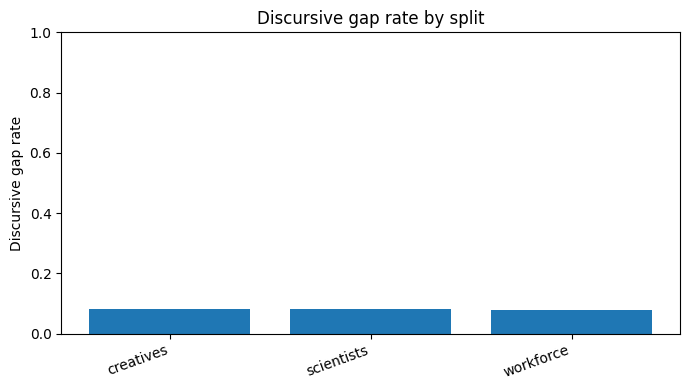

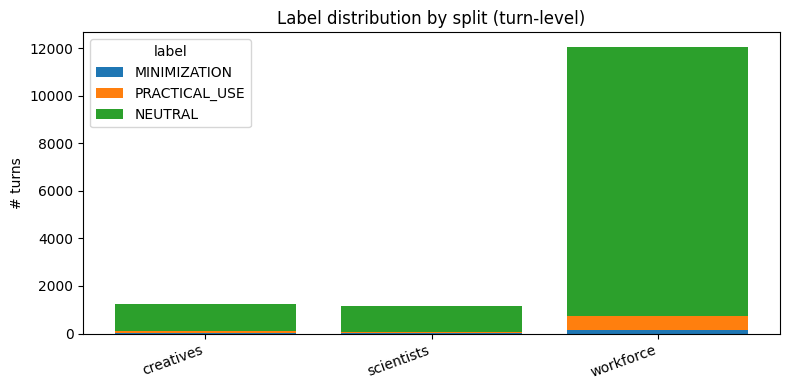

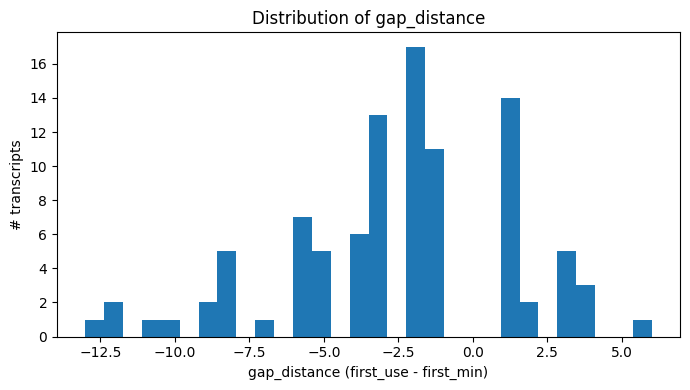

In [13]:
import matplotlib.pyplot as plt

# 1) Bar: discursive_gap rate by split
if "split" in df_metrics.columns and df_metrics["split"].nunique() > 0:
    rates = df_metrics.groupby("split")["discursive_gap"].mean().sort_index()
    plt.figure(figsize=(7, 4))
    plt.bar(rates.index.astype(str), rates.values)
    plt.ylim(0, 1)
    plt.ylabel("Discursive gap rate")
    plt.title("Discursive gap rate by split")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No 'split' available in df_metrics for split-level bar chart.")

# 2) Stacked bar: label distribution by split
if "split" in df_final_annot.columns:
    tmp = df_final_annot.copy()
    tmp = tmp[tmp["label"].notna()].copy()
    counts = (
        tmp.groupby(["split", "label"]).size().unstack("label").fillna(0).astype(int)
    )
    # Ensure consistent label order
    for col in ["MINIMIZATION", "PRACTICAL_USE", "NEUTRAL"]:
        if col not in counts.columns:
            counts[col] = 0
    counts = counts[["MINIMIZATION", "PRACTICAL_USE", "NEUTRAL"]]

    splits = counts.index.astype(str)
    bottoms = np.zeros(len(counts))

    plt.figure(figsize=(8, 4))
    for lab in counts.columns:
        vals = counts[lab].values
        plt.bar(splits, vals, bottom=bottoms, label=lab)
        bottoms += vals

    plt.ylabel("# turns")
    plt.title("Label distribution by split (turn-level)")
    plt.xticks(rotation=20, ha="right")
    plt.legend(title="label")
    plt.tight_layout()
    plt.show()
else:
    print("No 'split' available in df_final_annot for stacked bar chart.")

# 3) Histogram: gap_distance overall
vals = df_metrics["gap_distance"].dropna().astype(float)
if len(vals):
    plt.figure(figsize=(7, 4))
    plt.hist(vals.values, bins=30)
    plt.xlabel("gap_distance (first_use - first_min)")
    plt.ylabel("# transcripts")
    plt.title("Distribution of gap_distance")
    plt.tight_layout()
    plt.show()
else:
    print("No finite gap_distance values to plot.")

#### Interpretation

##### Graphe 1: Discursive gap rate by split




Ce graphe montre qu’environ 8 % des conversations, tous groupes confondus (creatives, scientists, workforce), présentent un discursive gap, c’est-à-dire qu’une même personne minimise son usage de l’IA à un moment et décrit un usage réel à un autre. Le taux est presque identique entre les trois groupes, ce qui indique que ce phénomène n’est pas propre à un type de métier particulier.


Cela montre que l’IA ne transforme pas seulement les tâches, mais aussi la manière dont les travailleurs parlent de leur travail. Les professionnels ressentent le besoin de justifier ou de nuancer leur usage de l’IA pour rester crédibles, compétents ou responsables. L’impact de l’IA est donc symbolique et social : elle modifie les normes de ce qu’il est acceptable de dire sur son travail.

##### Graphe 2: Label distribution by split (turn-level)




La majorité des répliques sont labellisées NEUTRAL, ce qui est normal car toutes les phrases ne parlent pas directement de l’IA. Parmi les répliques qui en parlent, PRACTICAL_USE est plus fréquent que MINIMIZATION, ce qui signifie que les personnes décrivent plus souvent des usages concrets que des discours de minimisation.


Cela indique que l’IA est déjà intégrée dans les pratiques quotidiennes : les travailleurs l’utilisent réellement pour accomplir des tâches. Cependant, l’existence récurrente de la minimisation montre que cette intégration reste socialement sensible. Le travail change, mais il n’est pas encore totalement légitimé : utiliser l’IA nécessite encore de se positionner, de rassurer ou de se défendre.

##### Graphe 3: Distribution of gap_distance




Le gap_distance est calculé comme la différence entre le tour où apparaît le premier usage pratique et le tour où apparaît la première minimisation. Des valeurs négatives signifient que l’usage pratique est mentionné avant la minimisation. L’histogramme montre que la majorité des valeurs sont négatives.


Cela suggère que les travailleurs utilisent d’abord l’IA, puis ajustent leur discours après coup pour se repositionner (“je l’utilise, mais pas trop”, “je vérifie toujours”). Psychologiquement, cela montre que l’IA transforme le travail plus vite que les normes professionnelles ne s’adaptent. Les individus doivent donc gérer une tension entre ce qu’ils font réellement et ce qu’ils estiment acceptable de dire sur leur travail.

##### Generalement

Ce qu’on peut conclure
L’ensemble de ces graphes montre que l’IA ne remplace pas directement le travail, mais qu’elle reconfigure les pratiques et les identités professionnelles. Les travailleurs l’utilisent concrètement, mais ils négocient en permanence la manière dont cet usage est présenté. L’impact de l’IA sur le travail est donc double : technique (nouvelles façons de faire) et symbolique (nouvelles façons de se définir comme professionnel). Cela confirme que l’enjeu principal n’est pas seulement la productivité, mais la redéfinition silencieuse de ce que signifie “bien travailler” à l’ère de l’IA.

### Axe 2: Travail invisible induit par l'IA (Embeddings)



Objectif : Utiliser des embeddings pour détecter et quantifier les "tâches ajoutées" par l'IA dans le discours des interviewés.

Catégories détectées : VERIFY (vérification), ITERATE (itérations de prompts), REWORK (réécriture manuelle), WORKAROUND (contournements).

Outputs attendus : % de tours concernés, % de conversations touchées, breakdown par split, exemples top par catégorie, graphes matplotlib.

 On va mesurer et cartographier le travail “en coulisse” créé par l’IA : vérifier, itérer, corriger, contourner, au lieu de “gagner du temps”.

#### embedding des phrases types

In [17]:
# Wide → long: df_final (1 row = 1 transcript) → df_turns (1 row = 1 human turn)
# Use df_turns for all Axe 2 embedding, similarity, metrics and plotting.

import pandas as pd

assert "df_final" in globals(), "df_final must exist"

# Human turn columns
human_turn_cols = [c for c in df_final.columns if isinstance(c, str) and c.startswith("human_turn_")]
if not human_turn_cols:
    raise ValueError("No columns starting with 'human_turn_' found in df_final")

id_vars = [c for c in ["split", "transcript_id"] if c in df_final.columns]
if "transcript_id" not in df_final.columns or "split" not in df_final.columns:
    raise ValueError("df_final must contain 'split' and 'transcript_id'")

# Melt wide → long
long = df_final.melt(
    id_vars=id_vars,
    value_vars=human_turn_cols,
    var_name="turn_col",
    value_name="human_text",
)

# turn_id from suffix (e.g. human_turn_01 → 1)
long["turn_id"] = long["turn_col"].str.replace("human_turn_", "", regex=False)
long["turn_id"] = pd.to_numeric(long["turn_id"], errors="coerce").astype("Int64")

# Cleaning: ensure string, drop empty or whitespace-only
long["human_text"] = long["human_text"].fillna("").astype(str)
long = long[long["human_text"].str.strip().str.len() > 0].copy()

# Stable row_id
long["row_id"] = long["transcript_id"].astype(str) + "::" + long["turn_id"].astype(str)

# Keep required columns only, sort
df_turns = long[["split", "transcript_id", "turn_id", "human_text", "row_id"]].copy()
df_turns = df_turns.sort_values(["transcript_id", "turn_id"]).reset_index(drop=True)

# For Axe 2: use df_turns as the only source
source_df = df_turns.copy()
TEXT_COL = "human_text"

print("df_turns shape:", df_turns.shape)
df_turns.head()

df_turns shape: (14495, 5)


,split,transcript_id,turn_id,human_text,row_id
0,creatives,creativity_0000,1,Nice! I think I'm good for questions. Let's ge...,creativity_0000::1
1,creatives,creativity_0000,2,Hmmm— I'm a media composer. That means I write...,creativity_0000::2
2,creatives,creativity_0000,3,"I use AI tools for brainstorming, asking quick...",creativity_0000::3
3,creatives,creativity_0000,4,Oh I should mention I also use some machine le...,creativity_0000::4
4,creatives,creativity_0000,5,This wasn't a client project but I've been usi...,creativity_0000::5


In [18]:
# Installer si besoin (décommenter si nécessaire)
# !pip install -U sentence-transformers scikit-learn

from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [19]:
# Sélection automatique de la source + colonne texte
# (Si df_turns existe, il est utilisé en priorité pour Axe 2.)

if "df_turns" in globals():
    source_df = df_turns.copy()
    TEXT_COL = "human_text"
    print("Using df_turns as source (1 row = 1 human turn)")
elif "df_final_annot" in globals():
    source_df = df_final_annot.copy()
    TEXT_COL = None
    print("Using df_final_annot as source")
elif "df_final" in globals():
    source_df = df_final.copy()
    TEXT_COL = None
    print("Using df_final as source")
else:
    raise ValueError("Neither df_turns, df_final_annot nor df_final found in globals()")

if TEXT_COL is None:
    # Détecter colonne texte (pour df_final_annot / df_final)
    text_candidates = ["human_text", "text", "turn_text", "utterance", "cleaned_text"]
    for col in text_candidates:
        if col in source_df.columns:
            TEXT_COL = col
            break
    if TEXT_COL is None:
        raise ValueError(f"Could not find text column. Expected one of: {text_candidates}")

print(f"TEXT_COL: {TEXT_COL}")

# Vérifier colonnes obligatoires
required_cols = ["transcript_id", "split"]
missing = [c for c in required_cols if c not in source_df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Créer row_id stable si pas déjà présent
if "row_id" not in source_df.columns:
    if "turn_id" in source_df.columns:
        source_df["row_id"] = (
            source_df["transcript_id"].astype(str) + "::" + source_df["turn_id"].astype(str)
        )
    else:
        source_df["row_id"] = source_df.index.astype(str)

print(f"Source shape: {source_df.shape}")
print(f"Columns: {list(source_df.columns)}")

Using df_turns as source (1 row = 1 human turn)
TEXT_COL: human_text
Source shape: (14495, 5)
Columns: ['split', 'transcript_id', 'turn_id', 'human_text', 'row_id']


In [20]:
# Prototypes Axe 2 (ENGLISH PROTOTYPES TO EMBED)

prototypes = {
    "VERIFY": [
        "I always double-check the AI output to make sure it is correct.",
        "I verify every result manually because I do not fully trust the AI.",
        "I review the AI's work carefully before using it in my job.",
        "I have to check each step produced by the AI, which takes extra time.",
        "I use AI suggestions but I always validate them myself.",
    ],
    "ITERATE": [
        "I need to rewrite my prompt several times to get a usable answer.",
        "It often takes multiple attempts before the AI gives what I want.",
        "I spend time adjusting my instructions until the AI understands.",
        "Using AI requires a lot of trial and error with prompts.",
        "I have to refine my prompts repeatedly to get acceptable results.",
    ],
    "REWORK": [
        "I usually rewrite the AI output in my own words afterward.",
        "The AI gives a draft, but I still have to redo a large part of it.",
        "I manually correct most of what the AI produces.",
        "The AI output needs significant editing before I can use it.",
        "I often redo the task myself after seeing the AI's answer.",
    ],
    "WORKAROUND": [
        "When the AI tool fails, I switch to another tool or do it manually.",
        "I copy and paste content between tools because the AI does not work properly.",
        "I have to find workarounds when the AI system makes mistakes.",
        "Using AI sometimes slows me down because I have to bypass its limitations.",
        "I rely on alternative methods when the AI does not behave as expected.",
    ],
}

# Flatten pour encodage
protos_flat = [
    (category, proto_text)
    for category, proto_list in prototypes.items()
    for proto_text in proto_list
]

print(f"Total prototypes: {len(protos_flat)}")
print(f"Categories: {list(prototypes.keys())}")

Total prototypes: 20
Categories: ['VERIFY', 'ITERATE', 'REWORK', 'WORKAROUND']


#### embedding des phrases et calcul de similarité avec les phrases types

In [21]:
# Embedding model + encodage

MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"  # Primary
# Fallback si trop lent: "sentence-transformers/all-MiniLM-L6-v2"

print(f"Loading model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)

# Préparer les textes
texts = source_df[TEXT_COL].fillna("").astype(str).tolist()
proto_texts_only = [p for (_, p) in protos_flat]

print(f"Encoding {len(texts)} texts...")
emb_texts = model.encode(
    texts, normalize_embeddings=True, batch_size=64, show_progress_bar=True
)

print(f"Encoding {len(proto_texts_only)} prototypes...")
emb_protos = model.encode(
    proto_texts_only, normalize_embeddings=True, batch_size=64, show_progress_bar=True
)

print(f"Text embeddings shape: {emb_texts.shape}")
print(f"Prototype embeddings shape: {emb_protos.shape}")

Loading model: sentence-transformers/all-mpnet-base-v2


c:\Users\Khyro\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encoding 14495 texts...


Batches:   0%|          | 0/227 [00:00<?, ?it/s]

Encoding 20 prototypes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text embeddings shape: (14495, 768)
Prototype embeddings shape: (20, 768)


In [22]:
# Similarité + classification Axe 2 au niveau "tour"

THRESH = 0.40  # Seuil ajustable

# Calcul cosine similarity
similarity_matrix = cosine_similarity(emb_texts, emb_protos)

# Pour chaque tour: best match
best_proto_indices = np.argmax(similarity_matrix, axis=1)
best_scores = np.max(similarity_matrix, axis=1)
best_categories = [protos_flat[idx][0] for idx in best_proto_indices]

# Créer df_axis2_turns
df_axis2_turns = source_df.copy()
df_axis2_turns["axis2_category"] = best_categories
df_axis2_turns["axis2_score"] = best_scores
df_axis2_turns["axis2_invisible"] = (best_scores >= THRESH) & (
    df_axis2_turns[TEXT_COL].astype(str).str.len() > 0
)

print(f"Threshold: {THRESH}")
print(f"Turns with invisible work: {df_axis2_turns['axis2_invisible'].sum()} / {len(df_axis2_turns)}")
print(f"Distribution by category:")
print(df_axis2_turns[df_axis2_turns["axis2_invisible"]]["axis2_category"].value_counts())

Threshold: 0.4
Turns with invisible work: 13146 / 14495
Distribution by category:
axis2_category
VERIFY        10871
ITERATE        1398
REWORK          499
WORKAROUND      378
Name: count, dtype: int64


In [23]:
# Mesures concrètes (tours + conversations + split)

# Output 1: Tours
total_turns = len(df_axis2_turns)
invisible_turns = df_axis2_turns["axis2_invisible"].sum()
pct_invisible_turns = (invisible_turns / total_turns * 100) if total_turns > 0 else 0

print("=" * 60)
print("OUTPUT 1 — TOURS")
print("=" * 60)
print(f"Total turns: {total_turns:,}")
print(f"Turns with invisible work: {invisible_turns:,}")
print(f"% turns with invisible work: {pct_invisible_turns:.2f}%")

# Output 2: Conversations
df_conv = (
    df_axis2_turns.groupby("transcript_id", as_index=False)
    .agg({"axis2_invisible": "any", "split": "first"})
    .rename(columns={"axis2_invisible": "axis2_any_invisible"})
)

total_conversations = len(df_conv)
conversations_with_invisible = df_conv["axis2_any_invisible"].sum()
pct_conversations = (
    (conversations_with_invisible / total_conversations * 100)
    if total_conversations > 0
    else 0
)

print("\n" + "=" * 60)
print("OUTPUT 2 — CONVERSATIONS")
print("=" * 60)
print(f"Total conversations: {total_conversations:,}")
print(f"Conversations with invisible work: {conversations_with_invisible:,}")
print(f"% conversations with invisible work: {pct_conversations:.2f}%")

# Output 3: Par split
print("\n" + "=" * 60)
print("OUTPUT 3 — PAR SPLIT")
print("=" * 60)

# % tours invisibles par split
split_turns = (
    df_axis2_turns.groupby("split")
    .agg(
        total=("axis2_invisible", "count"),
        invisible=("axis2_invisible", "sum"),
    )
    .assign(pct=lambda x: (x["invisible"] / x["total"] * 100).round(2))
)
print("\n% turns with invisible work by split:")
print(split_turns[["total", "invisible", "pct"]])

# % conversations avec invisible par split
split_conv = (
    df_conv.groupby("split")
    .agg(
        total=("axis2_any_invisible", "count"),
        with_invisible=("axis2_any_invisible", "sum"),
    )
    .assign(pct=lambda x: (x["with_invisible"] / x["total"] * 100).round(2))
)
print("\n% conversations with invisible work by split:")
print(split_conv[["total", "with_invisible", "pct"]])

# Distribution catégories par split (sur tours invisibles seulement)
print("\nCategory distribution by split (invisible turns only):")
cat_by_split = (
    df_axis2_turns[df_axis2_turns["axis2_invisible"]]
    .groupby(["split", "axis2_category"])
    .size()
    .unstack(fill_value=0)
)
print(cat_by_split)

OUTPUT 1 — TOURS
Total turns: 14,495
Turns with invisible work: 13,146
% turns with invisible work: 90.69%

OUTPUT 2 — CONVERSATIONS
Total conversations: 1,250
Conversations with invisible work: 1,250
% conversations with invisible work: 100.00%

OUTPUT 3 — PAR SPLIT

% turns with invisible work by split:
            total  invisible    pct
split                              
creatives    1259       1061  84.27
scientists   1160        888  76.55
workforce   12076      11197  92.72

% conversations with invisible work by split:
            total  with_invisible    pct
split                                   
creatives     125             125  100.0
scientists    125             125  100.0
workforce    1000            1000  100.0

Category distribution by split (invisible turns only):
axis2_category  ITERATE  REWORK  VERIFY  WORKAROUND
split                                              
creatives            49      52     939          21
scientists          104      18     706          

In [24]:
# Exemples convaincants (qualitatif)

print("=" * 60)
print("TOP EXAMPLES BY CATEGORY")
print("=" * 60)

for category in ["VERIFY", "ITERATE", "REWORK", "WORKAROUND"]:
    cat_turns = (
        df_axis2_turns[
            (df_axis2_turns["axis2_invisible"])
            & (df_axis2_turns["axis2_category"] == category)
        ]
        .nlargest(5, "axis2_score")[
            ["split", "transcript_id", "turn_id", "axis2_score", TEXT_COL]
            if "turn_id" in df_axis2_turns.columns
            else ["split", "transcript_id", "axis2_score", TEXT_COL]
        ]
    )

    print(f"\n--- {category} (top 5) ---")
    for idx, row in cat_turns.iterrows():
        text_preview = str(row[TEXT_COL])[:300] + ("..." if len(str(row[TEXT_COL])) > 300 else "")
        turn_info = f"turn_id={row['turn_id']}" if "turn_id" in row else ""
        print(
            f"\n[{row['split']}] {row['transcript_id']} {turn_info} | score={row['axis2_score']:.3f}"
        )
        print(f"Text: {text_preview}")

TOP EXAMPLES BY CATEGORY

--- VERIFY (top 5) ---

[workforce] work_0713 turn_id=9 | score=0.746
Text: I give it something, review the result, and give it further direction if required. AI: That's a clear process. You mentioned earlier that your AI use is pretty limited - about once a week for work-related tasks. How have your colleagues or your workplace culture influenced the way you use AI in your...

[workforce] work_0084 turn_id=8 | score=0.742
Text: Let it handle things independently AI: So you're more of a "delegate and verify" type of user. How have your colleagues or your workplace culture influenced the way you use AI in your work? Are people around you using it similarly, or have you seen different approaches?

[workforce] work_0934 turn_id=4 | score=0.731
Text: I write it and have it check me, or if I'm tight on time I'll tell it what I need and ask it to write it all, then I'll check it AI: I'm curious about your preferences when working with AI. Are there certain tasks you

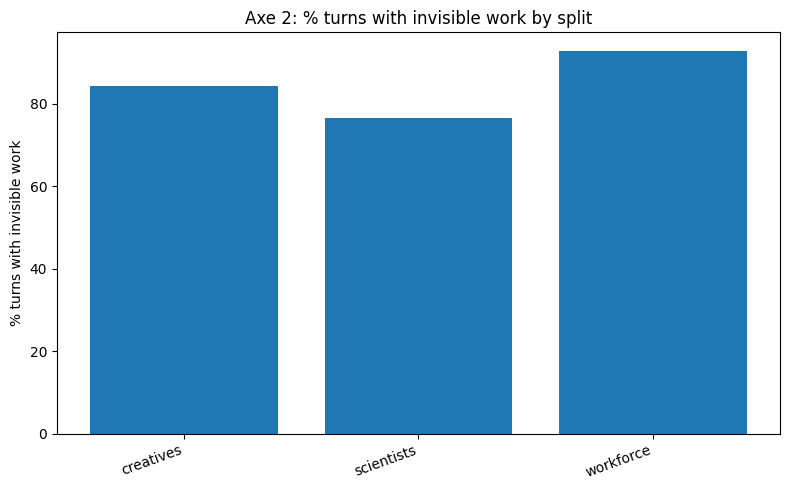

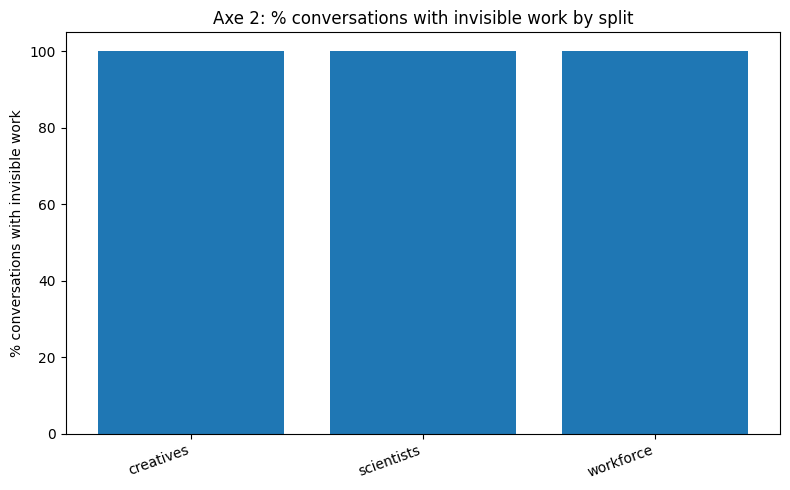

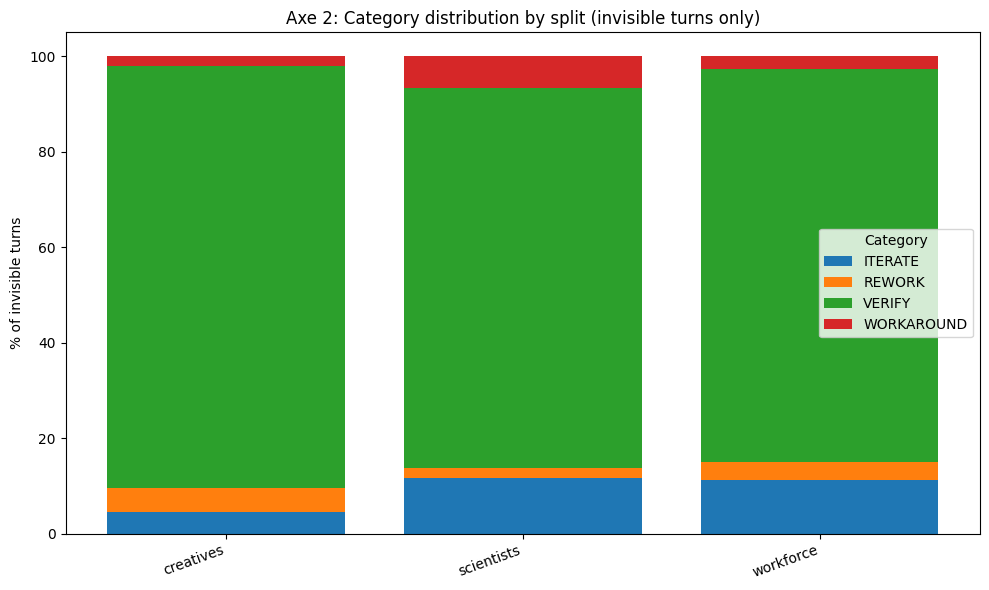

In [25]:
# Graphes matplotlib

# Graph 1: % turns with invisible work by split
plt.figure(figsize=(8, 5))
split_turns_pct = split_turns["pct"].sort_index()
plt.bar(split_turns_pct.index.astype(str), split_turns_pct.values)
plt.ylabel("% turns with invisible work")
plt.title("Axe 2: % turns with invisible work by split")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# Graph 2: % conversations with invisible work by split
plt.figure(figsize=(8, 5))
split_conv_pct = split_conv["pct"].sort_index()
plt.bar(split_conv_pct.index.astype(str), split_conv_pct.values)
plt.ylabel("% conversations with invisible work")
plt.title("Axe 2: % conversations with invisible work by split")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# Graph 3: Stacked bar — category distribution by split (invisible turns only)
plt.figure(figsize=(10, 6))
cat_by_split_norm = cat_by_split.div(cat_by_split.sum(axis=1), axis=0) * 100
splits = cat_by_split_norm.index.astype(str)
categories = cat_by_split_norm.columns
bottoms = np.zeros(len(splits))

for cat in categories:
    vals = cat_by_split_norm[cat].values
    plt.bar(splits, vals, bottom=bottoms, label=cat)
    bottoms += vals

plt.ylabel("% of invisible turns")
plt.title("Axe 2: Category distribution by split (invisible turns only)")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Category")
plt.tight_layout()
plt.show()

#### Interpretation

##### Graphe 1: % turns with invisible work by split

On observe que la très grande majorité des répliques humaines contiennent une forme de travail invisible lié à l’IA :

~93 % dans la workforce

~84 % chez les creatives

~77 % chez les scientists

Même dans le groupe le plus bas (scientists), plus de trois quarts des interventions décrivent du travail supplémentaire induit par l’IA.

Cela montre que l’IA n’élimine pas le travail, elle le déplace.
À chaque fois qu’un travailleur parle de l’IA, il parle en réalité de vérifier, reformuler, corriger ou contourner. L’impact principal n’est donc pas une automatisation nette, mais une transformation de la charge de travail vers des tâches cognitives de supervision, souvent non reconnues.

##### Graphe 2: % conversations with invisible work by split

Ici, le résultat est frappant : 100 % des conversations, dans tous les splits, contiennent au moins une occurrence de travail invisible.
Il n’existe aucune conversation où l’IA est utilisée sans générer de tâches supplémentaires.


Cela signifie que le travail invisible n’est pas un cas marginal ou un problème individuel :
c’est une propriété structurelle du travail avec l’IA.
Dès qu’un professionnel utilise l’IA, il doit assumer un rôle supplémentaire (contrôleur, vérificateur, ajusteur), ce qui transforme durablement la définition même du poste de travail.

##### Graphe 3: Category distribution by split (invisible turns only)

Dans tous les groupes, la catégorie VERIFY (vérification / double-check) domine très largement :

Environ 70–80 % des tâches invisibles

ITERATE (itérations de prompts) arrive loin derrière

REWORK et WORKAROUND restent minoritaires mais non négligeables

Les scientists ont un peu plus d’ITERATE et de WORKAROUND, tandis que la workforce est massivement concentrée sur VERIFY.



Cela montre que le principal effet de l’IA est de transformer les travailleurs en agents de contrôle qualité.
Le travail devient moins “faire” et plus “surveiller / vérifier / valider”.
C’est un changement profond : la responsabilité humaine augmente, même quand la production est partiellement automatisée, ce qui peut accroître charge mentale, vigilance permanente et fatigue cognitive.

##### Generalement

L’analyse montre que l’IA n’allège pas simplement le travail, mais qu’elle génère presque systématiquement des tâches invisibles : plus de 90 % des répliques et 100 % des conversations contiennent du travail supplémentaire lié à la vérification, à l’itération des prompts, à la reprise manuelle ou à des contournements techniques. Ce phénomène touche tous les groupes professionnels, avec une domination très nette des tâches de vérification, ce qui transforme les travailleurs en contrôleurs permanents de l’IA plutôt qu’en simples exécutants. L’impact sur le travail est donc clair : l’IA déplace l’effort vers une charge cognitive de supervision, largement absente des indicateurs de productivité, mais centrale dans l’expérience réelle du travail quotidien.